# "Supporting code" - download, and preprocess data, define metric.
Copied with small changes from https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/text_classification.ipynb

## Load data

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!pip install transformers

In [70]:
import transformers

print(transformers.__version__)

4.17.0


In [71]:
task = "cola"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

In [ ]:
!pip install datasets

In [73]:
from datasets import load_dataset, load_metric

In [74]:
actual_task = "mnli" if task == "mnli-mm" else task
dataset = load_dataset("glue", actual_task)
metric = load_metric('glue', actual_task)

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

In [ ]:
dataset["train"][0]

In [77]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(dataset["train"])

In [ ]:
metric

In [ ]:
import numpy as np

fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

## Preprocessing the data (casual encoding without dropping rare words)

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

In [83]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

In [ ]:
task

In [ ]:
sentence1_key, sentence2_key = task_to_keys[task]
if sentence2_key is None:
    print(f"Sentence: {dataset['train'][0][sentence1_key]}")
else:
    print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
    print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

In [102]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True, padding=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True, padding=True)

In [103]:
preprocess_function(dataset['train'][:5])

{'input_ids': [[101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102], [101, 2028, 2062, 18404, 2236, 3989, 1998, 1045, 1005, 1049, 3228, 2039, 1012, 102, 0, 0, 0, 0, 0], [101, 2028, 2062, 18404, 2236, 3989, 2030, 1045, 1005, 1049, 3228, 2039, 1012, 102, 0, 0, 0, 0, 0], [101, 1996, 2062, 2057, 2817, 16025, 1010, 1996, 13675, 16103, 2121, 2027, 2131, 1012, 102, 0, 0, 0, 0], [101, 2154, 2011, 2154, 1996, 8866, 2024, 2893, 14163, 8024, 3771, 1012, 102, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]}

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

# Fit model (my part)
Я успею сделать не все пайплайны потому что окно на выполнение задания было 3 дня, оно пересекалось с сессией (на ПМИ ВШЭ), Time-Series экзаменом сюда же и стажировкой по Computer Vision в Тиньке.
Обучение моделей занимает слишком много времени, поэтому я всего лишь напишу код для обучения, возможно в тому моменту как Вы будете это проверять уже появятся результаты.

## Some prepations

In [239]:
show_random_elements(encoded_dataset['train'])

,sentence,label,idx,input_ids,attention_mask
0,The umpire fell the deck off.,unacceptable,3593,"[101, 1996, 20887, 3062, 1996, 5877, 2125, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Bill sent London a package.,unacceptable,2266,"[101, 3021, 2741, 2414, 1037, 7427, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Peter is owners.,unacceptable,8348,"[101, 2848, 2003, 5608, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Look after herself!,unacceptable,8085,"[101, 2298, 2044, 2841, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"Who is Ann going to send a picture to her teacher of, as soon as she gets home?",unacceptable,1489,"[101, 2040, 2003, 5754, 2183, 2000, 4604, 1037, 3861, 2000, 2014, 3836, 1997, 1010, 2004, 2574, 2004, 2016, 4152, 2188, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5,We love their.,unacceptable,771,"[101, 2057, 2293, 2037, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,Bob is too thin for me to be able to squeeze into jacket.,unacceptable,1796,"[101, 3960, 2003, 2205, 4857, 2005, 2033, 2000, 2022, 2583, 2000, 11025, 2046, 6598, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7,Amanda burned the stove black.,acceptable,2504,"[101, 8282, 5296, 1996, 16247, 2304, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8,Doug removed the tabletop of scratches.,unacceptable,2621,"[101, 8788, 3718, 1996, 13855, 7361, 1997, 25980, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9,The computer is playing six simultaneous games of three dimensional chess.,acceptable,6916,"[101, 1996, 3274, 2003, 2652, 2416, 17424, 2399, 1997, 2093, 8789, 7433, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [240]:
full_input = encoded_dataset['train']['input_ids']

input = []
for i in full_input:
    input.append(i[0 : min(len(i), 16)])
input = np.array(input)
input.shape

(8551, 16)

In [241]:
target = np.array(encoded_dataset['train']['label'])

In [242]:
full_val = encoded_dataset['validation']['input_ids']

val_input = []
for i in full_val:
    val_input.append(i[0 : min(len(i), 16)])
val_input = np.array(val_input)
val_input.shape

(1043, 16)

In [243]:
val_target = np.array(encoded_dataset['validation']['label'])

In [244]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers, models
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

## Basic Approaches

### Basic Convolution approach (Conv1D)

In [245]:
def block(out_size, num = 3):
    return models.Sequential([
                    layers.Conv1D(out_size, num, activation='relu', padding='same')
                    ])

In [ ]:
from keras.layers.pooling import MaxPooling1D
base_conv = models.Sequential([
    layers.Input(shape=(16, 1)),
    block(8),
    layers.AveragePooling1D(),
    block(64),
    layers.MaxPooling1D(),
    block(512),
    layers.MaxPooling1D(),
    block(2048),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

base_conv.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True));

base_conv.summary()

In [247]:
optimizer = tf.optimizers.Adam(learning_rate=2e-4)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [248]:
losses = []

In [ ]:
batch_size = 16

for epoch in range(19):
    for i in tqdm(range(input.shape[0] // batch_size)):
        
        input_batch = input[i * batch_size : (i + 1) * batch_size, :]
        target_batch = target[i * batch_size : (i + 1) * batch_size].reshape(-1, 1)

        with tf.GradientTape() as tape:
            prediction = base_conv(input_batch)
            error = loss(target_batch, prediction)
            losses.append(error)

        gradient = tape.gradient(error, base_conv.variables)
        optimizer.apply_gradients(zip(gradient, base_conv.variables))
    
    print(np.mean(np.round(base_conv.predict(val_input)) == val_target, axis=None))
    print(matthews_corrcoef(2 * val_target - 1, 2 * np.round(base_conv.predict(val_input)) - 1))

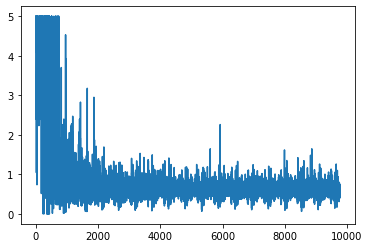

In [264]:
plt.plot(np.array(losses).clip(0, 5))

In [265]:
np.mean(np.round(base_conv.predict(val_input)) == val_target, axis=None)

0.566628272857722

In [268]:
matthews_corrcoef(2 * val_target - 1, 2 * np.round(base_conv.predict(val_input)) - 1)

0.01795464826604878

Very bad - conv1d is good for low resources and long text, but now texts are very short

### Basic LSTM

In [309]:
base_lstm = keras.Sequential([
    layers.Embedding(input_dim=30000, output_dim=100),
    layers.LSTM(1024),
    layers.Dense(1)
])

base_lstm.summary()

Model: "sequential_171"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 100)         3000000   
                                                                 
 lstm_9 (LSTM)               (None, 1024)              4608000   
                                                                 
 dense_57 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 7,609,025
Trainable params: 7,609,025
Non-trainable params: 0
_________________________________________________________________


In [310]:
optimizer = tf.optimizers.Adam(learning_rate=2e-4)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [311]:
losses = []

In [312]:
batch_size = 16

for epoch in range(10):
    for i in tqdm(range(input.shape[0] // batch_size)):
        
        input_batch = input[i * batch_size : (i + 1) * batch_size, :]
        target_batch = target[i * batch_size : (i + 1) * batch_size].reshape(-1, 1)

        with tf.GradientTape() as tape:
            prediction = base_lstm(input_batch)
            error = loss(target_batch, prediction)
            losses.append(error)

        gradient = tape.gradient(error, base_lstm.variables)
        optimizer.apply_gradients(zip(gradient, base_lstm.variables))

    print(epoch, '-> acc =', np.mean(np.round(base_lstm.predict(val_input)) == val_target, axis=None))
    print(epoch, '-> matt =', matthews_corrcoef(2 * val_target - 1, 2 * np.round(base_lstm.predict(val_input)) - 1))

100%|██████████| 534/534 [05:38<00:00,  1.58it/s]


0 -> acc = 0.6487288217390466
0 -> matt = 0.04744856483374793


100%|██████████| 534/534 [05:38<00:00,  1.58it/s]


1 -> acc = 0.6520298313460784
1 -> matt = 0.061330868783120274


100%|██████████| 534/534 [06:04<00:00,  1.47it/s]


2 -> acc = 0.6063819519069282
2 -> matt = 0.11185046696694158


 11%|█         | 57/534 [00:36<05:03,  1.57it/s]


KeyboardInterrupt: ignored

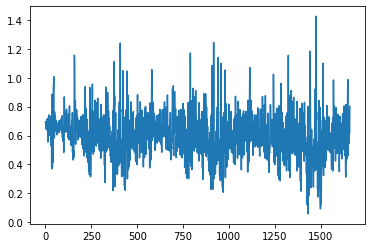

In [313]:
plt.plot(np.array(losses).clip(0, 5))

In [314]:
print('acc =', np.mean(np.round(base_lstm.predict(val_input)) == val_target, axis=None))
print('matt =', matthews_corrcoef(2 * val_target - 1, 2 * np.round(base_lstm.predict(val_input)) - 1))

acc = 0.3826532910357963
matt = 0.05122381482424856


In [315]:
# still no time to train. matt increases and best in all the models

### Basic GRU

In [316]:
base_gru = keras.Sequential([
    layers.Embedding(input_dim=30000, output_dim=100),
    layers.GRU(1024),
    layers.Dense(1)
])

base_gru.summary()

Model: "sequential_172"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 100)         3000000   
                                                                 
 gru (GRU)                   (None, 1024)              3459072   
                                                                 
 dense_58 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 6,460,097
Trainable params: 6,460,097
Non-trainable params: 0
_________________________________________________________________


In [317]:
optimizer = tf.optimizers.Adam(learning_rate=2e-4)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [318]:
losses = []

In [319]:
batch_size = 16

for epoch in range(10):
    for i in tqdm(range(input.shape[0] // batch_size)):
        
        input_batch = input[i * batch_size : (i + 1) * batch_size, :]
        target_batch = target[i * batch_size : (i + 1) * batch_size].reshape(-1, 1)

        with tf.GradientTape() as tape:
            prediction = base_gru(input_batch)
            error = loss(target_batch, prediction)
            losses.append(error)

        gradient = tape.gradient(error, base_gru.variables)
        optimizer.apply_gradients(zip(gradient, base_gru.variables))

    print(epoch, '-> acc =', np.mean(np.round(base_gru.predict(val_input)) == val_target, axis=None))
    print(epoch, '-> matt =', matthews_corrcoef(2 * val_target - 1, 2 * np.round(base_gru.predict(val_input)) - 1))

100%|██████████| 534/534 [04:46<00:00,  1.87it/s]


0 -> acc = 0.6505627159651753
0 -> matt = 0.025113533218145526


100%|██████████| 534/534 [04:44<00:00,  1.88it/s]


1 -> acc = 0.6659674274646573
1 -> matt = 0.02252809667115044


100%|██████████| 534/534 [04:53<00:00,  1.82it/s]


2 -> acc = 0.6641335332385285
2 -> matt = 0.03358268164168073


  0%|          | 2/534 [00:01<06:27,  1.37it/s]


KeyboardInterrupt: ignored

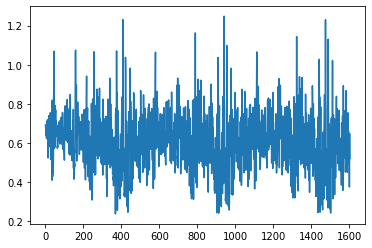

In [320]:
plt.plot(np.array(losses).clip(0, 5))

In [321]:
print('acc =', np.mean(np.round(base_gru.predict(val_input)) == val_target, axis=None))
print('matt =', matthews_corrcoef(2 * val_target - 1, 2 * np.round(base_gru.predict(val_input)) - 1))

acc = 0.6667009851551089
matt = 0.019600143757033554


In [322]:
# увеличивается, но слабо

### Basic RNN

In [325]:
base_rnn = keras.Sequential([
    layers.Embedding(input_dim=30000, output_dim=1000),
    layers.SimpleRNN(1024),
    layers.Dense(1)
])

base_rnn.summary()

Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 1000)        30000000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 1024)              2073600   
                                                                 
 dense_59 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 32,074,625
Trainable params: 32,074,625
Non-trainable params: 0
_________________________________________________________________


In [326]:
optimizer = tf.optimizers.Adam(learning_rate=2e-4)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [327]:
losses = []

In [ ]:
batch_size = 16

for epoch in range(10):
    for i in tqdm(range(input.shape[0] // batch_size)):
        
        input_batch = input[i * batch_size : (i + 1) * batch_size, :]
        target_batch = target[i * batch_size : (i + 1) * batch_size].reshape(-1, 1)

        with tf.GradientTape() as tape:
            prediction = base_rnn(input_batch)
            error = loss(target_batch, prediction)
            losses.append(error)

        gradient = tape.gradient(error, base_rnn.variables)
        optimizer.apply_gradients(zip(gradient, base_rnn.variables))

    print(epoch, '-> acc =', np.mean(np.round(base_rnn.predict(val_input)) == val_target, axis=None))
    print(epoch, '-> matt =', matthews_corrcoef(2 * val_target - 1, 2 * np.round(base_rnn.predict(val_input)) - 1))

100%|██████████| 534/534 [06:36<00:00,  1.35it/s]


0 -> acc = 0.6021350389622089
0 -> matt = 0.009780229596506032


 30%|██▉       | 159/534 [01:58<04:36,  1.36it/s]

In [ ]:
plt.plot(np.array(losses).clip(0, 5))

In [ ]:
print('acc =', np.mean(np.round(base_rnn.predict(val_input)) == val_target, axis=None))
print('matt =', matthews_corrcoef(2 * val_target - 1, 2 * np.round(base_rnn.predict(val_input)) - 1))

## HP tuning

### HP tuning (optuna) + Conv1D 

### HP tuning + RNN

### HP tuning + GRU

### HP tuning + LSTM

## Transformers